Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [150]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import lab9_lib
import sys

from tqdm import tqdm
from dataclasses import dataclass
from copy import deepcopy
from collections import deque

## Numeric Values

In [161]:
INSTANCES = [1, 2, 5, 10]
LOCI_GENOMES = 1000
POPULATION_SIZE = 300
TOURNAMENT_SIZE = 50
OFFSPRINGS = 150
MAX_GENERATIONS = 500
# N_CUT_XOVER_PROB = .8
MAX_CUT_POINTS = 30
MIN_CUT_POINTS = 2
TABU_LENGHT = 16384 # ~2kb
MUTATION_PROBABILITY = .2
XOVER_PROBABILITY = .8
THRESHOLD_IMPROVEMENT = 1e-2
SCALING_FACTOR_PROB = .8

## Evolutionary Strategy Functions

In [133]:
@dataclass
class Individual:
    genotype: list[bool]
    fitness: float

    def __str__(self):
        return f"{self.genotype}: {self.fitness:.2%}"

    def fitness(self) -> float:
        return fitness

def mutation(ind: Individual) -> None:
    gene = rnd.choice([i for i in range(LOCI_GENOMES)])
    ind.genotype[gene] = 1 - ind.genotype[gene] 
    ind.fitness = None


def one_cut_xover(ind1: Individual, ind2: Individual) -> Individual:
    cut_point = int(len(ind1.genotype) / 2)
    offspring = Individual(genotype=np.concatenate((ind1.genotype[:cut_point], ind2.genotype[cut_point:]), axis=None), fitness=None)
    return offspring

def n_cut_xover(ind1: Individual, ind2: Individual, cuts: int) -> Individual:
    cut_points = np.linspace(0, LOCI_GENOMES, cuts + 1, dtype=int)
    inds = (ind1, ind2)
    ind_turn = 0
    prev_cut_point = 0
    offspring = Individual(genotype=np.zeros(LOCI_GENOMES), fitness=None)

    for cut in cut_points:
        offspring.genotype[prev_cut_point:cut] = inds[ind_turn].genotype[prev_cut_point:cut]
        prev_cut_point = cut
        ind_turn = 1 - ind_turn

    assert len(offspring.genotype) == LOCI_GENOMES

    return offspring

def select_parent(population: list) -> Individual:
    pool = [rnd.choice(population) for _ in range(TOURNAMENT_SIZE)]
    champion = max(pool, key=lambda i: i.fitness)
    return champion

## Tabu Table

In [141]:
# Tabu table will remember if a recent state was already been anlized
# When the table is full it removes the oldest state that was analized
# The dimension of the table is a cruicial and though parameter to decide

@dataclass
class TabuCache:
    table: deque

    def __init__(self, size) -> None:
        self.table = deque(maxlen=size)

    def tabu_add(self, state: list) -> bool:
        try:
            hit = False
            if self.table.index(state) >= 0:
                self.table.remove(state)
                hit = True
        except ValueError:
            pass
        finally:
            self.table.append(state)
        
        return hit

    def get_table(self) -> deque:
        return self.table


## Population Generation

In [167]:
fitness = list()
population = list()

for idx, inst in enumerate(INSTANCES):
    fitness.append(lab9_lib.make_problem(inst))
    population.append([
        Individual(
            genotype = rnd.choices([0, 1], k=LOCI_GENOMES),
            fitness = None,
        )
        for _ in range(POPULATION_SIZE)
    ])

    for i in population[idx]:
        i.fitness = fitness[idx](i.genotype)

## Training

Solving for instance: 1


 81%|████████▏ | 407/500 [00:11<00:02, 35.49it/s]


Reached fitness maximum before 500 generations!
Number of fitness calls: 61500 => fitness: 1.0
Solving for instance: 2


100%|██████████| 500/500 [00:14<00:00, 35.02it/s]


Number of fitness calls: 75300 => fitness: 0.524
Solving for instance: 5


100%|██████████| 500/500 [00:14<00:00, 33.51it/s]


Number of fitness calls: 75300 => fitness: 0.416
Solving for instance: 10


100%|██████████| 500/500 [00:15<00:00, 32.69it/s]


Number of fitness calls: 75300 => fitness: 0.216


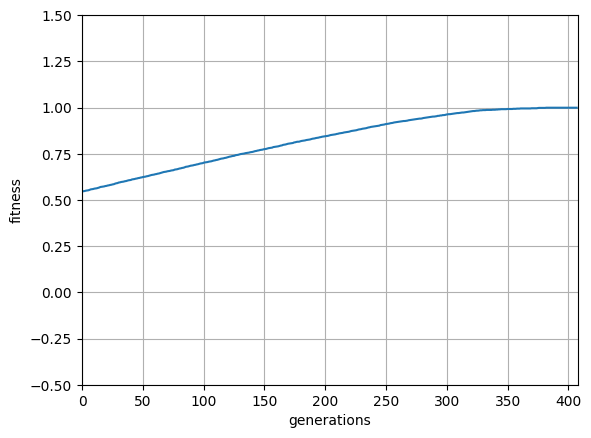

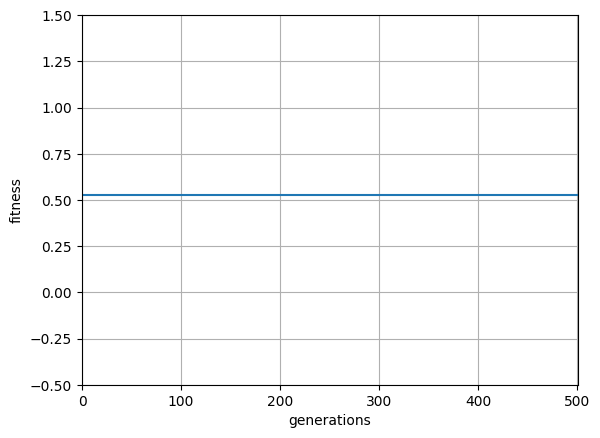

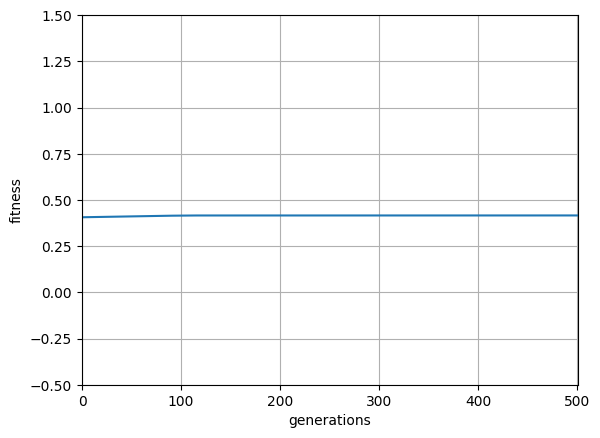

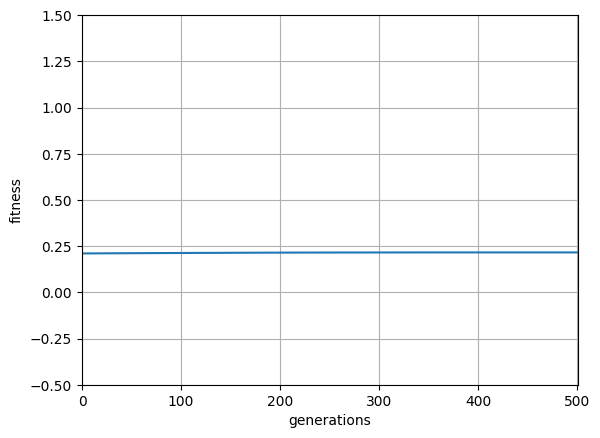

In [168]:
tabu = TabuCache(size=TABU_LENGHT)
hit = True
prev_best_fitness = 0
delta_improv_fitness = sys.maxsize 
mutation_probability = MUTATION_PROBABILITY
xover_probability = XOVER_PROBABILITY
threshold_improvement = THRESHOLD_IMPROVEMENT
n_cut_points = MIN_CUT_POINTS

# for the graphs
x = np.linspace(0, MAX_GENERATIONS, MAX_GENERATIONS)
y = np.zeros(MAX_GENERATIONS)
stop = MAX_GENERATIONS

for idx, inst in enumerate(INSTANCES):
    print(f"Solving for instance: {inst}")

    # for plotting
    stop = MAX_GENERATIONS

    for gen in tqdm(range(MAX_GENERATIONS)):
        offsprings = list()

        for _ in range(OFFSPRINGS):
            hit = True
            while hit:
                p1 = select_parent(population[idx])
                p2 = select_parent(population[idx])
                o = deepcopy(p1)

                if rnd.random() < xover_probability:
                    o = n_cut_xover(p1, p2, rnd.choice([k for k in range(n_cut_points)]))
                    if rnd.random() < mutation_probability:
                        mutation(o)
                else: 
                    mutation(o)

                hit = tabu.tabu_add(o)
                if hit:
                    continue
            
            offsprings.append(o)

        for o in offsprings:
            o.fitness = fitness[idx](o.genotype)

        population[idx].extend(offsprings)
        population[idx].sort(key=lambda i: i.fitness, reverse=True)
        population[idx] = population[idx][:POPULATION_SIZE]

        # updating graph
        y[gen] = population[idx][0].fitness

        if population[idx][0].fitness == 1:
            print(f"Reached fitness maximum before {MAX_GENERATIONS} generations!")
            stop = gen
            break
        # print(f"Best individual of the generation: {population[idx][0].fitness}")

        delta = population[idx][0].fitness - prev_best_fitness
        prev_best_fitness = population[idx][0].fitness

        if threshold_improvement > 1/OFFSPRINGS and delta < threshold_improvement:
            n_cut_points *= 2 
            if n_cut_points > MAX_CUT_POINTS:
                n_cut_points = MAX_CUT_POINTS
            threshold_improvement *= .1
            xover_probability *= SCALING_FACTOR_PROB
            mutation_prbability = 1 - xover_probability

    print(f"Number of fitness calls: {fitness[idx].calls} => fitness: {population[idx][0].fitness}")
    plt.figure()
    plt.grid()
    plt.plot(x[:stop], y[:stop])
    plt.xlabel('generations')
    plt.ylabel('fitness')
    plt.ylim(-0.5, 1.5)
    plt.xlim(-0.5, stop + 0.5)
    plt.savefig(f"instance{inst}.png")
